Accuracy: 0.9753086419753086
Precision: 0.9714285714285714
Recall: 0.9714285714285714
F1 Score: 0.9714285714285714
ROC AUC Score: 0.993167701863354


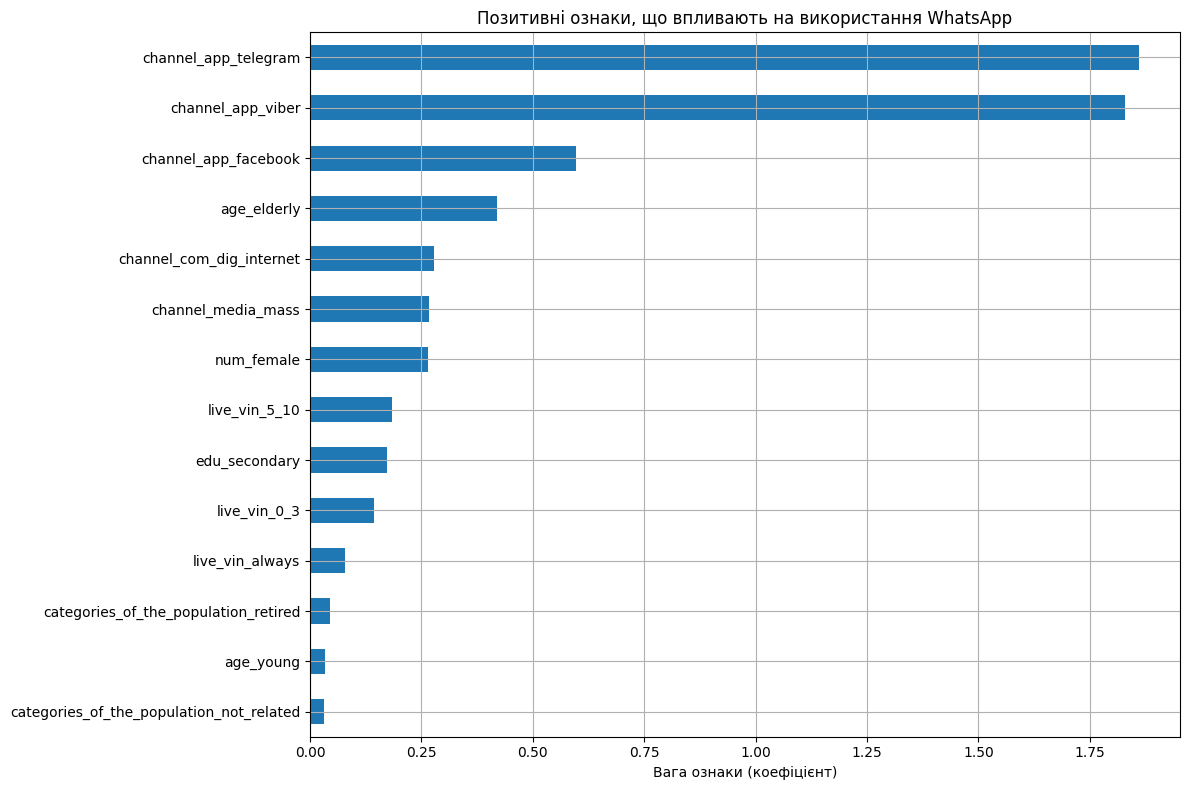

Діаграму збережено у файл: /content/positive_features_whatsapp.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Встановлення бібліотек
!pip install --quiet gspread gspread_dataframe

# Імпорти
import pandas as pd
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Авторизація
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Завантаження даних
df = pd.read_csv("/content/optimized_data.csv")

# Попередня обробка
df = df.dropna(how='all')
df = df.fillna(0)

# Відокремлення цільової змінної
y = df['channel_app_whatsapp']
X = df.drop(columns=['channel_app_whatsapp'])
# Масштабування ознак
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Розділення на тренувальні та тестові дані
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Побудова моделі логістичної регресії
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
# Вибір ознак
coef_series = pd.Series(model.coef_[0], index=X.columns)
positive_features = coef_series[coef_series > 0].sort_values()
# Побудова та збереження графіка позитивних ознак
plt.figure(figsize=(12, 8))
positive_features.plot(kind='barh')
plt.title('Позитивні ознаки, що впливають на використання WhatsApp')
plt.xlabel('Вага ознаки (коефіцієнт)')
plt.grid(True)
plt.tight_layout()

# Оцінка моделі
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Побудова та збереження графіка позитивних ознак
plt.figure(figsize=(12, 8))
positive_features.plot(kind='barh')
plt.title('Позитивні ознаки, що впливають на використання WhatsApp')
plt.xlabel('Вага ознаки (коефіцієнт)')
plt.grid(True)
plt.tight_layout()

# Збереження графіка до файлу до show()
plot_path = "/content/positive_features_whatsapp.png"
plt.savefig(plot_path)
plt.show()

print(f"Діаграму збережено у файл: {plot_path}")

# Код для скачування у Google Colab
from google.colab import files
files.download(plot_path)


In [ ]:
# Встановлення бібліотек
!pip install --quiet gspread gspread_dataframe xgboost

# Імпорти
import pandas as pd
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# Авторизація
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Завантаження даних
df = pd.read_csv("/content/optimized_data.csv")
 # Залишаємо лише числові ознаки
X = X.select_dtypes(include=[np.number])

# Попередня обробка
df = df.dropna(how='all')
df = df.fillna(0)

# Цільова змінна — WhatsApp
y = df['channel_app_whatsapp']
X = df.drop(columns=['channel_app_whatsapp'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Logistic Regression
log_params = {'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 500]}
log_model = GridSearchCV(LogisticRegression(), log_params, cv=5, scoring='accuracy', n_jobs=-1)
log_model.fit(X_train, y_train)
log_best = log_model.best_estimator_
# Random Forest
rf_params = {'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
# XGBoost
xgb_params = { 'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]}
xgb_model = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
#  Метрики
def print_metrics(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred
    print(f"\n{name} Метрики:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Виведення метрик
print_metrics("Logistic Regression", log_best, X_test, y_test)
print_metrics("Random Forest", rf_best, X_test, y_test)
print_metrics("XGBoost", xgb_best, X_test, y_test)

# Найкращі параметри XGBoost
print("\nXGBoost найкращі параметри:")
print(xgb_model.best_params_)
print("Точність XGBoost на тренуванні:", accuracy_score(y_train, xgb_best.predict(X_train)))



Logistic Regression Метрики:
Accuracy: 0.9753086419753086
Precision: 0.9714285714285714
Recall: 0.9714285714285714
F1 Score: 0.9714285714285714
ROC AUC Score: 0.993167701863354

Random Forest Метрики:
Accuracy: 0.9753086419753086
Precision: 0.9714285714285714
Recall: 0.9714285714285714
F1 Score: 0.9714285714285714
ROC AUC Score: 0.9962732919254659

XGBoost Метрики:
Accuracy: 0.9753086419753086
Precision: 0.9714285714285714
Recall: 0.9714285714285714
F1 Score: 0.9714285714285714
ROC AUC Score: 0.9925465838509318

XGBoost найкращі параметри:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Точність XGBoost на тренуванні: 0.9783950617283951


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Налаштування гіперпараметрів
params = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

# Підбір параметрів і тренування моделі
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb = GridSearchCV(model, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
model_xgb.fit(X_train, y_train)

# Оцінка точності на тренувальних даних
y_pred_train = model_xgb.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Точність XGBoost на тренувальних даних:", acc_train)

# Вивід найкращих гіперпараметрів
print("Найкращі гіперпараметри XGBoost:", model_xgb.best_params_)

Точність XGBoost на тренувальних даних: 0.9783950617283951
Найкращі гіперпараметри XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
# Імпорти
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Завантаження даних
df = pd.read_csv("/content/optimized_data.csv")
df = df.dropna(how='all').fillna(0)
# Цільова змінна — WhatsApp
y = df['channel_app_whatsapp']
X = df.drop(columns=['channel_app_whatsapp'])
X = X.select_dtypes(include=[np.number])
# Масштабування
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Розділення даних
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
#  XGBoost
params_xgb = { 'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]}
model_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=params_xgb,scoring='accuracy', cv=5,n_jobs=-1)
model_xgb.fit(X_train, y_train)
y_pred_train = model_xgb.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Точність XGBoost на тренувальних даних:", acc_train)
print("Найкращі гіперпараметри XGBoost:", model_xgb.best_params_)

# Logistic Regression
params_log = {'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 500]}
model_log = GridSearchCV(LogisticRegression(), param_grid=params_log,
    scoring='accuracy',cv=5, n_jobs=-1)
model_log.fit(X_train, y_train)
y_pred_train = model_log.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("\nТочність Logistic Regression на тренувальних даних:", acc_train)
print("Найкращі гіперпараметри Logistic Regression:", model_log.best_params_)

# Random Forest
params_rf = {'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]}
model_rf = GridSearchCV( RandomForestClassifier(), param_grid=params_rf,
    scoring='accuracy',  cv=5, n_jobs=-1)
model_rf.fit(X_train, y_train)
y_pred_train = model_rf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("\nТочність Random Forest на тренувальних даних:", acc_train)
print("Найкращі гіперпараметри Random Forest:", model_rf.best_params_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Точність XGBoost на тренувальних даних: 0.9783950617283951
Найкращі гіперпараметри XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Точність Logistic Regression на тренувальних даних: 0.9598765432098766
Найкращі гіперпараметри Logistic Regression: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Точність Random Forest на тренувальних даних: 0.9629629629629629
Найкращі гіперпараметри Random Forest: {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 600x500 with 0 Axes>

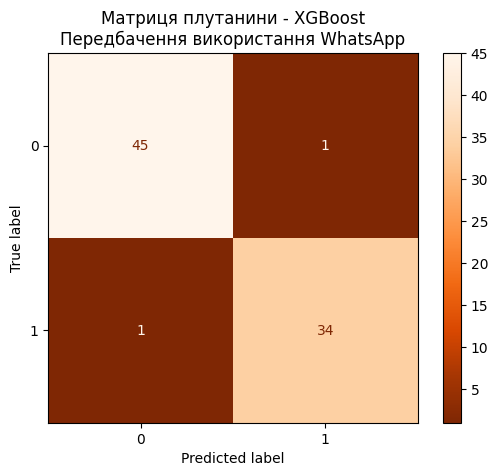

<Figure size 600x500 with 0 Axes>

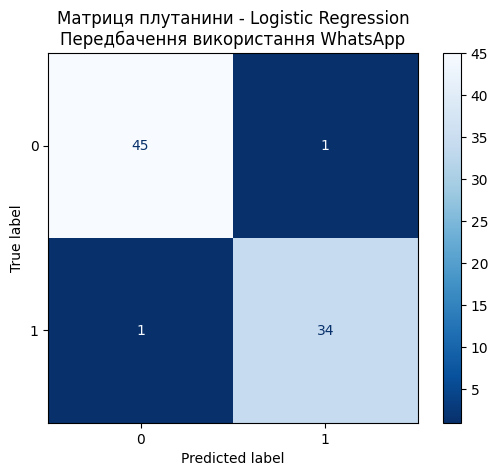

<Figure size 600x500 with 0 Axes>

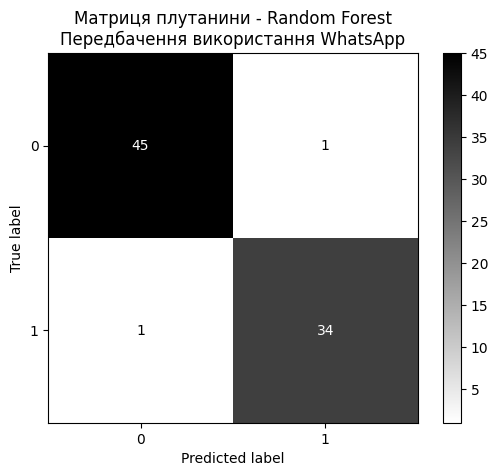

Точність моделей на тестових даних (channel_app_whatsapp):
XGBoost:             0.9753
Logistic Regression: 0.9753
Random Forest:       0.9753


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Матриця XGBoost
y_pred_xgb = xgb_best.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb).plot(cmap='Oranges_r', values_format='d')
plt.title('Матриця плутанини - XGBoost\nПередбачення використання WhatsApp')
plt.show()

# Матриця Logistic Regression
y_pred_log = log_best.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
plt.figure(figsize=(6, 5))
cm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm_log).plot(cmap='Blues_r', values_format='d')
plt.title('Матриця плутанини - Logistic Regression\nПередбачення використання WhatsApp')
plt.show()

# === Random Forest ===
y_pred_rf = rf_best.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap='binary', values_format='d')
plt.title('Матриця плутанини - Random Forest\nПередбачення використання WhatsApp')
plt.show()

# === Підсумок точності моделей ===
print("Точність моделей на тестових даних (channel_app_whatsapp):")
print(f"XGBoost:             {acc_xgb:.4f}")
print(f"Logistic Regression: {acc_log:.4f}")
print(f"Random Forest:       {acc_rf:.4f}")


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")  # Вимкнення всіх попереджень

# Цільова змінна
y = df['channel_app_whatsapp']
X = df.drop(columns=['channel_app_whatsapp'])

# Масштабування
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Розділення на тренувальні і тестові дані
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Словник моделей
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42)
}

# Порівняння моделей
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    print(f"\n{name} (channel_app_whatsapp):")
    print(f"Крос-валідація:     середнє = {cv_mean:.3f}, std = {cv_std:.3f}")
    print(f"Точність train:     {train_acc:.3f}")
    print(f"Точність test:      {test_acc:.3f}")

    if train_acc - test_acc > 0.1:
        print("Можливе перенавчання (overfitting)")
    else:
        print("Модель узагальнює добре")



LogisticRegression (channel_app_whatsapp):
Крос-валідація:     середнє = 0.951, std = 0.011
Точність train:     0.960
Точність test:      0.975
Модель узагальнює добре

RandomForest (channel_app_whatsapp):
Крос-валідація:     середнє = 0.948, std = 0.012
Точність train:     0.994
Точність test:      0.975
Модель узагальнює добре

XGBoost (channel_app_whatsapp):
Крос-валідація:     середнє = 0.954, std = 0.019
Точність train:     0.991
Точність test:      0.963
Модель узагальнює добре



Logistic Regression метрики:
Accuracy: 0.8271604938271605
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.6172707889125799

Random Forest метрики:
Accuracy: 0.8395061728395061
Precision: 1.0
Recall: 0.07142857142857142
F1 Score: 0.13333333333333333
ROC AUC Score: 0.6332622601279317

XGBoost метрики:
Accuracy: 0.8148148148148148
Precision: 0.4
Recall: 0.14285714285714285
F1 Score: 0.21052631578947367
ROC AUC Score: 0.7110874200426439


<Figure size 600x500 with 0 Axes>

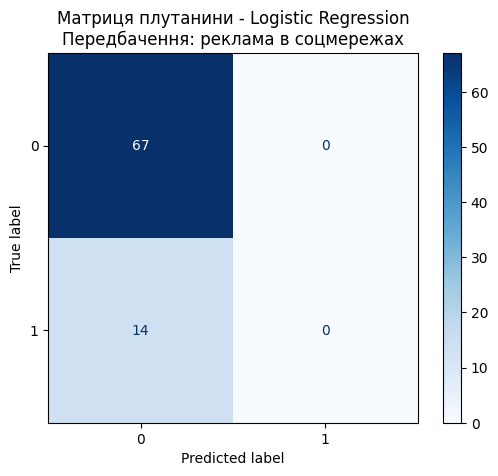

<Figure size 600x500 with 0 Axes>

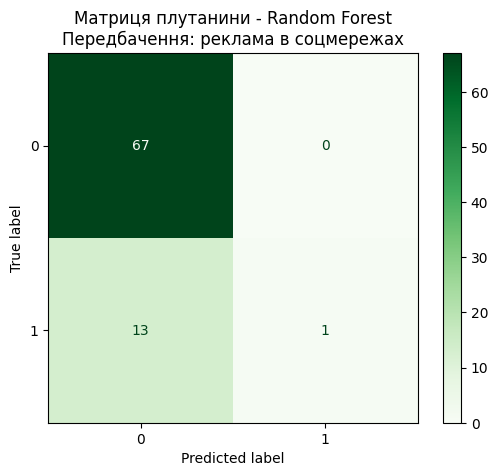

<Figure size 600x500 with 0 Axes>

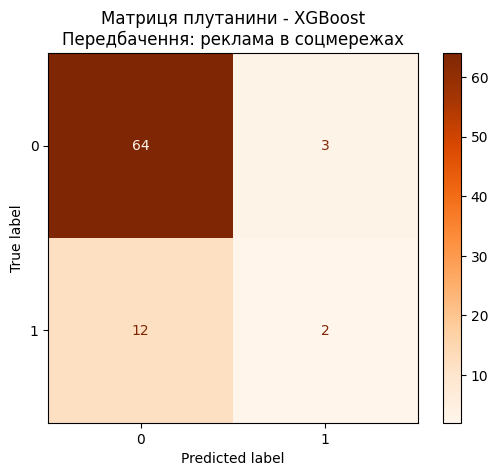


Logistic Regression:
Крос-валідація (середнє): 0.806 ± 0.007
Train Accuracy: 0.806, Test Accuracy: 0.827
Модель узагальнює добре

Random Forest:
Крос-валідація (середнє): 0.806 ± 0.007
Train Accuracy: 0.815, Test Accuracy: 0.840
Модель узагальнює добре

XGBoost:
Крос-валідація (середнє): 0.809 ± 0.028
Train Accuracy: 0.898, Test Accuracy: 0.815
Модель узагальнює добре


In [ ]:
# === 1. Імпорти ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# === 2. Завантаження та обробка даних ===
df = pd.read_csv("/content/optimized_data - optimized_data.csv.csv")
df = df.dropna(how='all').fillna(0)

# === 3. Формування ознак та цільової змінної ===
y = df['channel_media_social_ads']
X = df.drop(columns=['channel_media_social_ads']).select_dtypes(include=[np.number])

# === 4. Масштабування та поділ на train/test ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === 5. Параметри моделей ===
param_log = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 500]
}

param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

param_xgb = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

# === 6. Навчання моделей з GridSearchCV ===
log_model = GridSearchCV(LogisticRegression(), param_log, cv=5, scoring='accuracy', n_jobs=-1)
log_model.fit(X_train, y_train)
log_best = log_model.best_estimator_

rf_model = GridSearchCV(RandomForestClassifier(), param_rf, cv=5, scoring='accuracy', n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_

xgb_model = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_xgb, cv=5, scoring='accuracy', n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_

# === 7. Функція для оцінки ===
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n{name} метрики:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# === 8. Виведення метрик ===
evaluate_model("Logistic Regression", log_best, X_test, y_test)
evaluate_model("Random Forest", rf_best, X_test, y_test)
evaluate_model("XGBoost", xgb_best, X_test, y_test)

# === 9. Побудова матриць плутанини ===
for model, label, cmap in zip([log_best, rf_best, xgb_best],
                               ["Logistic Regression", "Random Forest", "XGBoost"],
                               ['Blues', 'Greens', 'Oranges']):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    ConfusionMatrixDisplay(cm).plot(cmap=cmap, values_format='d')
    plt.title(f'Матриця плутанини - {label}\nПередбачення: реклама в соцмережах')
    plt.show()

# === 10. Порівняння моделей через крос-валідацію ===
models = {
    "Logistic Regression": log_best,
    "Random Forest": rf_best,
    "XGBoost": xgb_best
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    print(f"\n{name}:")
    print(f"Крос-валідація (середнє): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")
    if train_acc - test_acc > 0.1:
        print("Можливе перенавчання")
    else:
        print("Модель узагальнює добре")
